# Seoul Bike Sharing Demand Analysis

**Group 2: Xiao Hu, Vinky Wang, Izzy Zhang**

## 1. Introduction

### 1.1 Motivation

The bike-sharing system has made public transportation cleaner and more convenient as citizens can get access to bicycles across the city. As of 2020, 3200 bikes were being offered in Seoul, South Korea [1]. However, imbalance in demand and bicycles supplied can create problems for both users and system operators. Predicting bicycle usage helps guide companies to control the amount of bikes to deploy. In our project, we will be using different environmental variables and time as predictors for the hourly count of bike rentals.

The dataset was collected by the website of “South Korea Public Holidays” [2] and used by Sathishkumar et al. to test different data mining techniques and to make inferences and predictions [1].

### 1.2 Dataset Description

In [48]:
# install.packages("AER")

In [49]:
# Load packages
library(tidyverse)
library(lubridate)
library(corrplot)
library(car)
library(repr)
library(broom)
library(MASS)
library(rsample)
library(DHARMa)
library(AER)

We first read data from its source. 

In [50]:
# Load data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00560/SeoulBikeData.csv"
bike = read.csv(url,check.names=F)

**Variable Information:**

- Date : year-month-day
- Rented Bike count - Count of bikes rented at each hour (our response variable)
- Hour - Hour of the day
- Temperature-Temperature in Celsius
- Humidity - %
- Windspeed - m/s
- Visibility - 10m
- Dew point temperature - Celsius
- Solar radiation - MJ/m2
- Rainfall - mm
- Snowfall - cm
- Seasons - Winter, Spring, Summer, Autumn
- Holiday - Holiday/No holiday
- Functional Day - NoFunc(Non Functional Hours), Fun(Functional hours)

For easier understanding, we breifly clean the data by giving names to columns, changing data types, and making sense of the date variable. We will do more tidying in the next section. 

In [51]:
# Rename columns
colnames(bike) <- c("date", "count", "hour", "temp", "humidity", "windspeed", "visibility", "dew", "solar", "rain", "snow", "seasons", "holiday", "functioning")

# Convert variable into different classes
bike <- bike %>%
  mutate(date = as.POSIXct(date, format = "%d/%m/%Y"), # date
         month =  factor(months(date)),      # add months variable
         seasons = factor(seasons), # factor
         holiday = factor(holiday), # factor
         functioning = factor(functioning)) # factor
head(bike)

,date,count,hour,temp,humidity,windspeed,visibility,dew,solar,rain,snow,seasons,holiday,functioning,month
,<dttm>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>
1,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0,0,0,Winter,No Holiday,Yes,December
2,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0,0,0,Winter,No Holiday,Yes,December
3,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0,0,0,Winter,No Holiday,Yes,December
4,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0,0,0,Winter,No Holiday,Yes,December
5,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0,0,0,Winter,No Holiday,Yes,December
6,2017-12-01,100,5,-6.4,37,1.5,2000,-18.7,0,0,0,Winter,No Holiday,Yes,December


Table 1. Tidy tibble of Seoul bike sharing data. 

## 2. Methods and Results

### 2.1 Exploratory Data Analysis

#### 2.1.1 Data Cleaning

We noticed that count becomes zero when `functioning == "No"`. So we proceeded with removing all rows when the bike sharing system is not functioning and the `functioning` column. 

In [52]:
## remove functioning == "No" rows from the dataset. 
bike <- bike[which(bike$functioning == "Yes"),]
bike <- subset(bike, select = -functioning)

We are also removing the `date` column since we do not plan to do time series analysis. 

In [53]:
bike <- subset(bike, select = -date)
head(bike)

,count,hour,temp,humidity,windspeed,visibility,dew,solar,rain,snow,seasons,holiday,month
,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>
1,254,0,-5.2,37,2.2,2000,-17.6,0,0,0,Winter,No Holiday,December
2,204,1,-5.5,38,0.8,2000,-17.6,0,0,0,Winter,No Holiday,December
3,173,2,-6.0,39,1.0,2000,-17.7,0,0,0,Winter,No Holiday,December
4,107,3,-6.2,40,0.9,2000,-17.6,0,0,0,Winter,No Holiday,December
5,78,4,-6.0,36,2.3,2000,-18.6,0,0,0,Winter,No Holiday,December
6,100,5,-6.4,37,1.5,2000,-18.7,0,0,0,Winter,No Holiday,December


Table 2. Finalized tidy tibble of Seoul bike sharing data. 

After cleaning the data, we split the dataframe into training and testing for further analyses. We chose a proportion of 70/30. 

In [54]:
set.seed(34567)
bike_split <- initial_split(bike, prop = 0.7)
bike_training <- training(bike_split)
bike_testing <- testing(bike_split)

#### 2.1.2 Multi-collinearity
We have tested for multi-collinearity in the whole dataset in our proposal. Now we will identify variables in the training set that are correlated with one another and select a subset of the dataset that minimizes multicollinearity. 

,temp,humidity,windspeed,visibility,dew,solar,rain,snow
temp,1.00000000,0.1539553,-0.03197670,0.03636107,0.9136303,0.36161865,0.05607276,-0.21245692
humidity,0.15395525,1.0000000,-0.33148340,-0.55201175,0.5296681,-0.45802066,0.24539100,0.10985523
windspeed,-0.03197670,-0.3314834,1.00000000,0.18717004,-0.1696710,0.32598825,-0.03217295,-0.01145729
visibility,0.03636107,-0.5520118,0.18717004,1.00000000,-0.1778320,0.16187554,-0.17153928,-0.12838257
dew,0.91363031,0.5296681,-0.16967095,-0.17783202,1.0000000,0.10404535,0.13379372,-0.14603775
solar,0.36161865,-0.4580207,0.32598825,0.16187554,0.1040453,1.00000000,-0.07705423,-0.07186494
rain,0.05607276,0.2453910,-0.03217295,-0.17153928,0.1337937,-0.07705423,1.00000000,0.01653452
snow,-0.21245692,0.1098552,-0.01145729,-0.12838257,-0.1460377,-0.07186494,0.01653452,1.00000000


Warning message in text.default(pos.xlabel[, 1], pos.xlabel[, 2], newcolnames, srt = tl.srt, :
“"use" is not a graphical parameter”
Warning message in text.default(pos.ylabel[, 1], pos.ylabel[, 2], newrownames, col = tl.col, :
“"use" is not a graphical parameter”
Warning message in title(title, ...):
“"use" is not a graphical parameter”


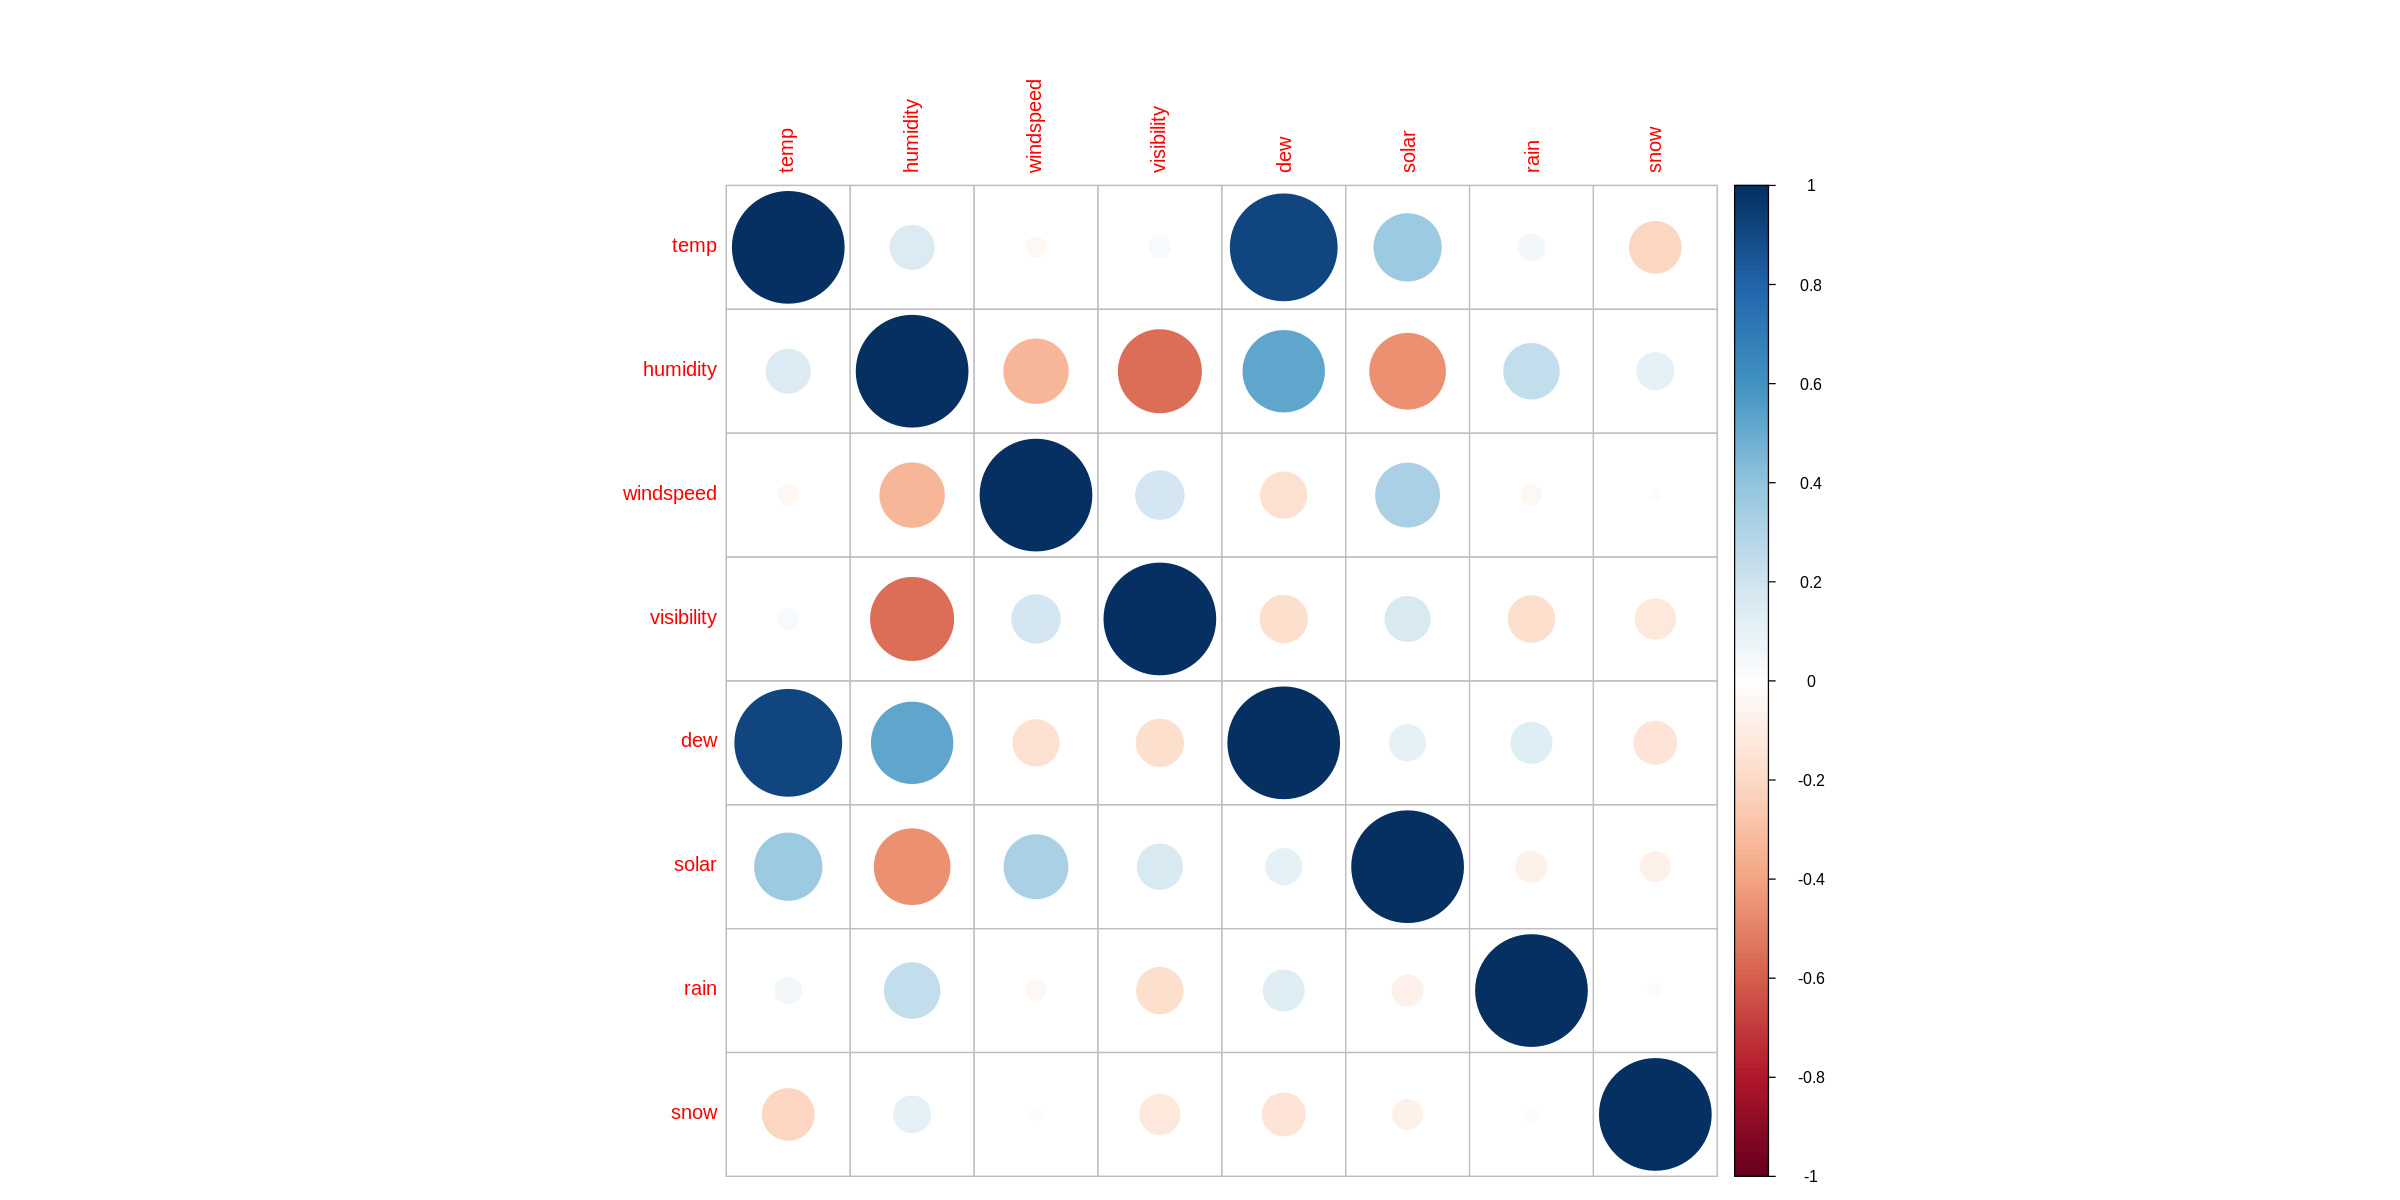

In [55]:
# Select only numeric environmental variables
bike_var <- bike_training %>%
  dplyr::select(c(temp, humidity, windspeed, visibility, dew, solar, rain, snow))

# Correlation matrix
cor_matrix <- cor(bike_var)
cor_matrix

# Correlation plot
corrplot(cor_matrix, use = "complete.obs", method="circle")

Figure 1. Correlation plot for predictor variables. 

We see from the correlation plot a strong positive correlation between `dew` and `temp`, a relatively strong positive correlation between `dew` and `humidity`, a strong negative correlation between `visibility` and `humidity`, and a relatively strong negative correlation between `solar` and `humidity`. 

We proceed to test the observations above using variance inflation factors (VIF). 

In [56]:
# Variance inflation factor selection with all numerical variables
model_vif1 <- glm(count~ temp + humidity + windspeed + visibility + dew + solar + rain + snow, data = bike_training,family = poisson)
vif(model_vif1)

temp   humidity  windspeed visibility        dew      solar       rain 
 47.711475  11.736937   1.184112   1.382702  59.455206   1.960071   1.057594 
      snow 
  1.040290

We see that `temp`, `humidity` and `dew` have VIFs larger than 5, suggesting high correlation with other variables. We start by removing `dew`, which has the highest VIF. 

In [57]:
## remove dew variable
model_vif2 <- glm(count~ temp + humidity + windspeed + visibility + solar + rain + snow, data = bike_training,family = poisson)
vif(model_vif2)

temp   humidity  windspeed visibility      solar       rain       snow 
  1.429081   2.007410   1.180126   1.380984   1.854448   1.050448   1.040015

All VIFs are now lower than 5. We can then remove `dew` from our testing set and continue with model fitting. 

In [58]:
bike_training <- subset(bike_training, select = -dew)
head(bike_training)

,count,hour,temp,humidity,windspeed,visibility,solar,rain,snow,seasons,holiday,month
,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>
1459,100,18,-2.3,91,0.4,202,0.00,1.4,2.0,Winter,No Holiday,January
596,184,19,-1.8,41,2.1,2000,0.00,0.0,0.0,Winter,Holiday,December
1330,187,9,-16.2,33,2.9,2000,0.19,0.0,0.6,Winter,No Holiday,January
8695,287,6,2.6,33,1.5,1185,0.00,0.0,0.0,Autumn,No Holiday,November
7441,1049,0,16.3,86,0.3,2000,0.00,0.0,0.0,Autumn,No Holiday,October
1729,112,0,-6.9,36,2.1,2000,0.00,0.0,0.0,Winter,No Holiday,February


Lastly, we visualize all the varibles to help guide our analysis. 

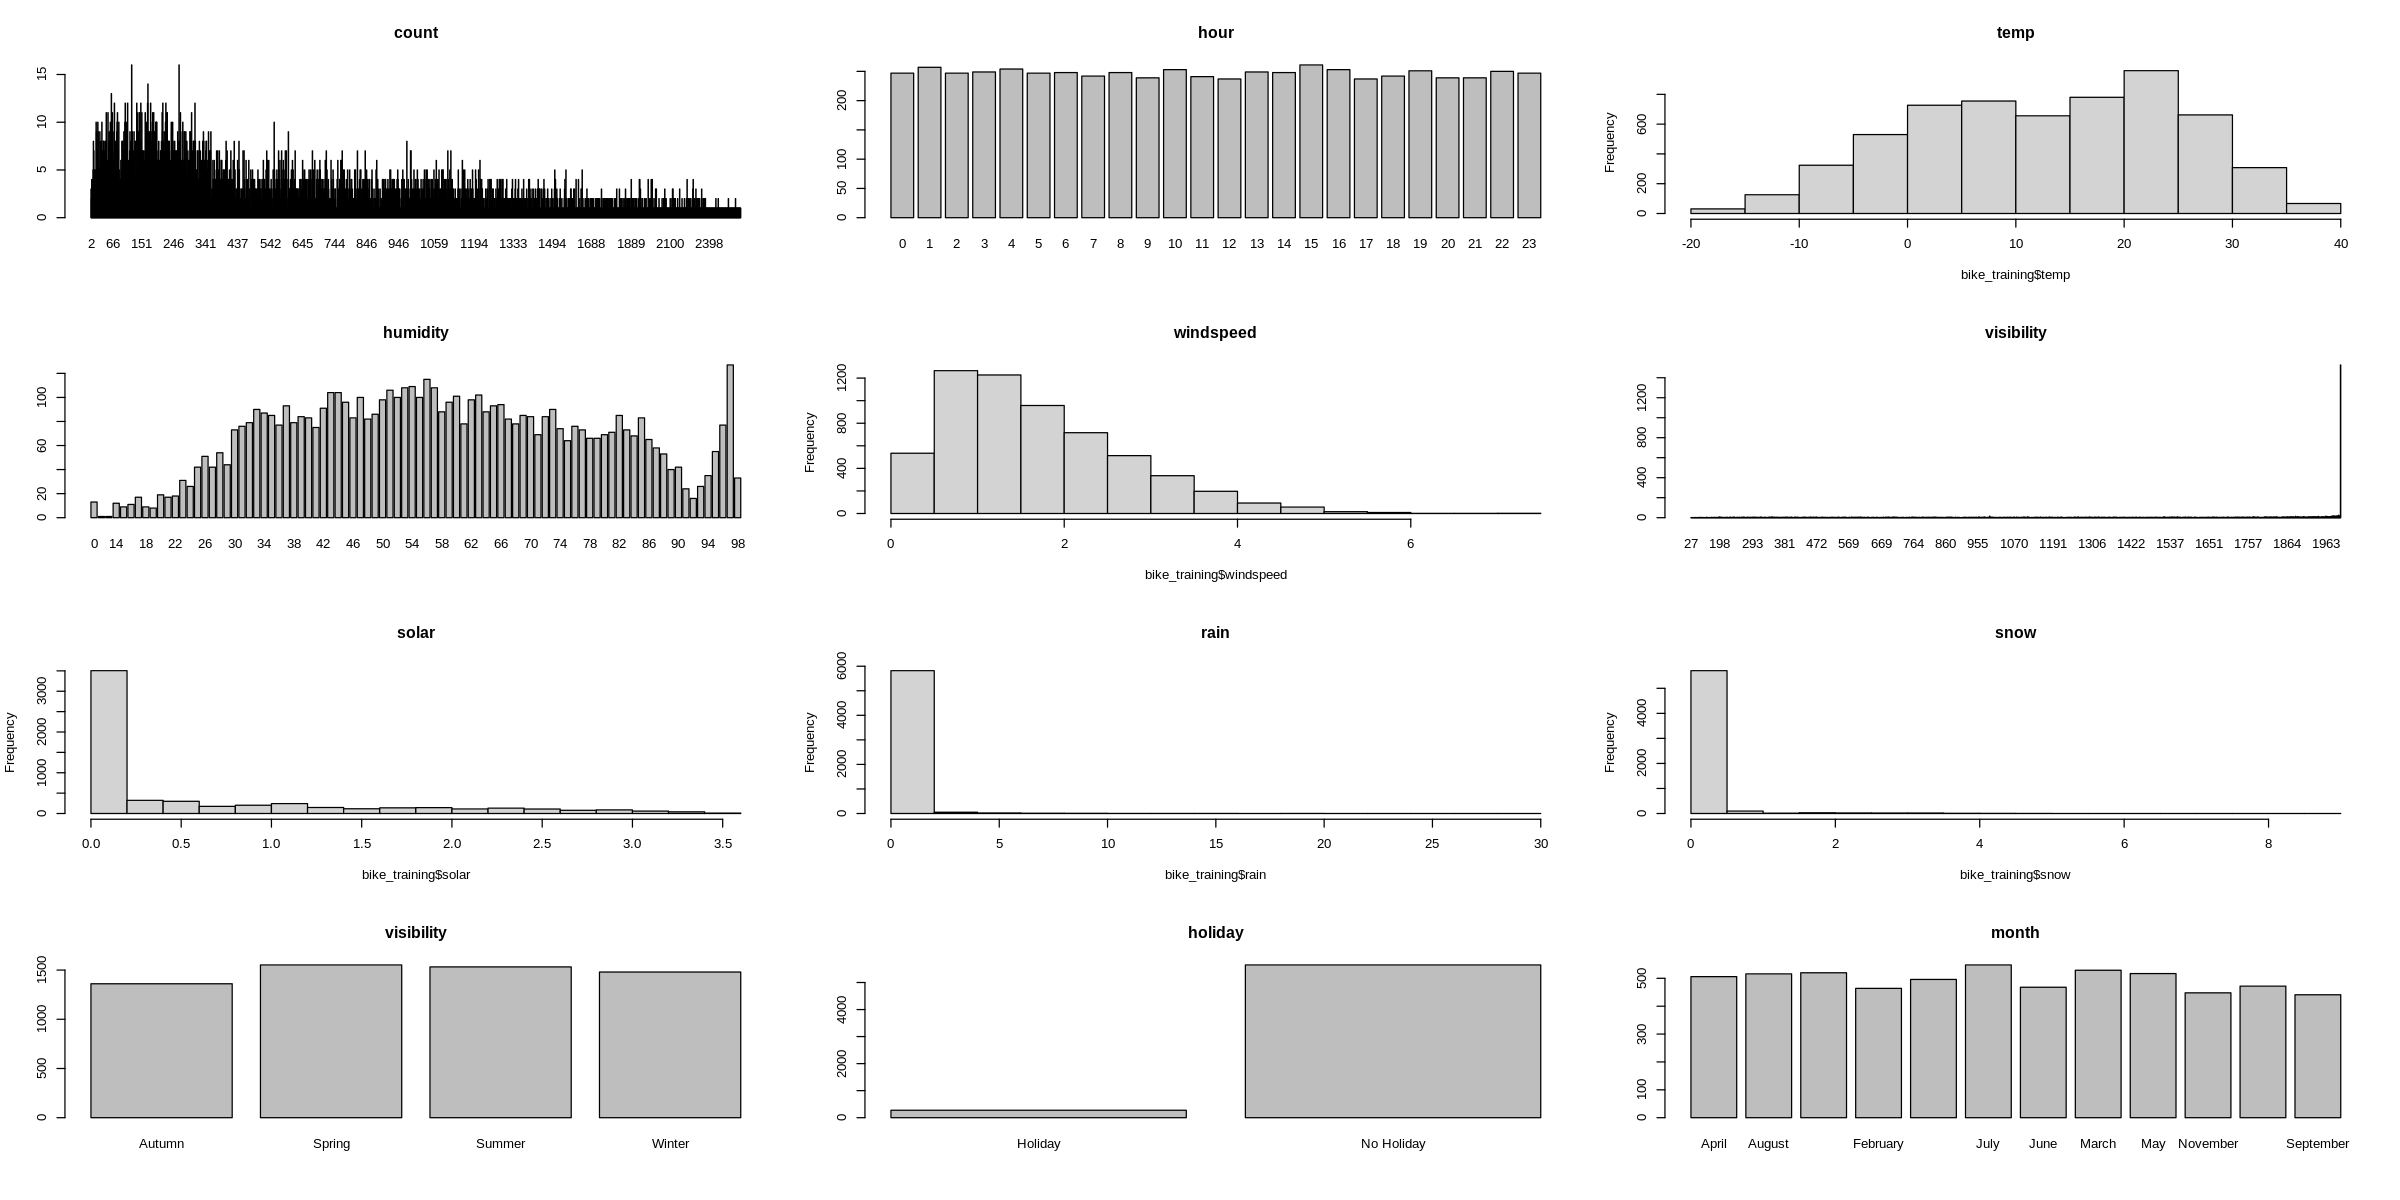

In [95]:
## plot the variables
par(mfrow=c(4,3))
barplot(table(bike_training$count), main = "count")
barplot(table(bike_training$hour), main = "hour")
hist(bike_training$temp, main = "temp")
barplot(table(bike_training$humidity), main = "humidity")
hist(bike_training$windspeed, main = "windspeed")
barplot(table(bike_training$visibility), main = "visibility")
hist(bike_training$solar, main = "solar")
hist(bike_training$rain, main = "rain")
hist(bike_training$snow, main = "snow")
barplot(table(bike_training$seasons), main = "visibility")
barplot(table(bike_training$holiday), main = "holiday")
barplot(table(bike_training$month), main = "month")

Figure 3. Visualization for all variables.

Note: 
- `visibility` has many data with values of 2000
- `solar`, `rain` and `snow` has many data with values of 0

### 2.2 Model Selection

#### Poisson Regression

Since the response variable of bike rentals correspond to count data, we will first fit a full Poisson model with all variables in the data and evaluate its performance. 

$$
P(Y_i = y_i, \lambda_i, \theta) = \frac{\lambda_i^{y_i}}{y_i!} e^{-\lambda_i}  \quad \text{for} \  y_i \in \{0, 1, \cdots \}$$

Then:

$$E[Y_i]= \lambda_i$$

and 

$$V[Y_i] = \lambda_i$$

Let's explore the distribution of bike rentals. 

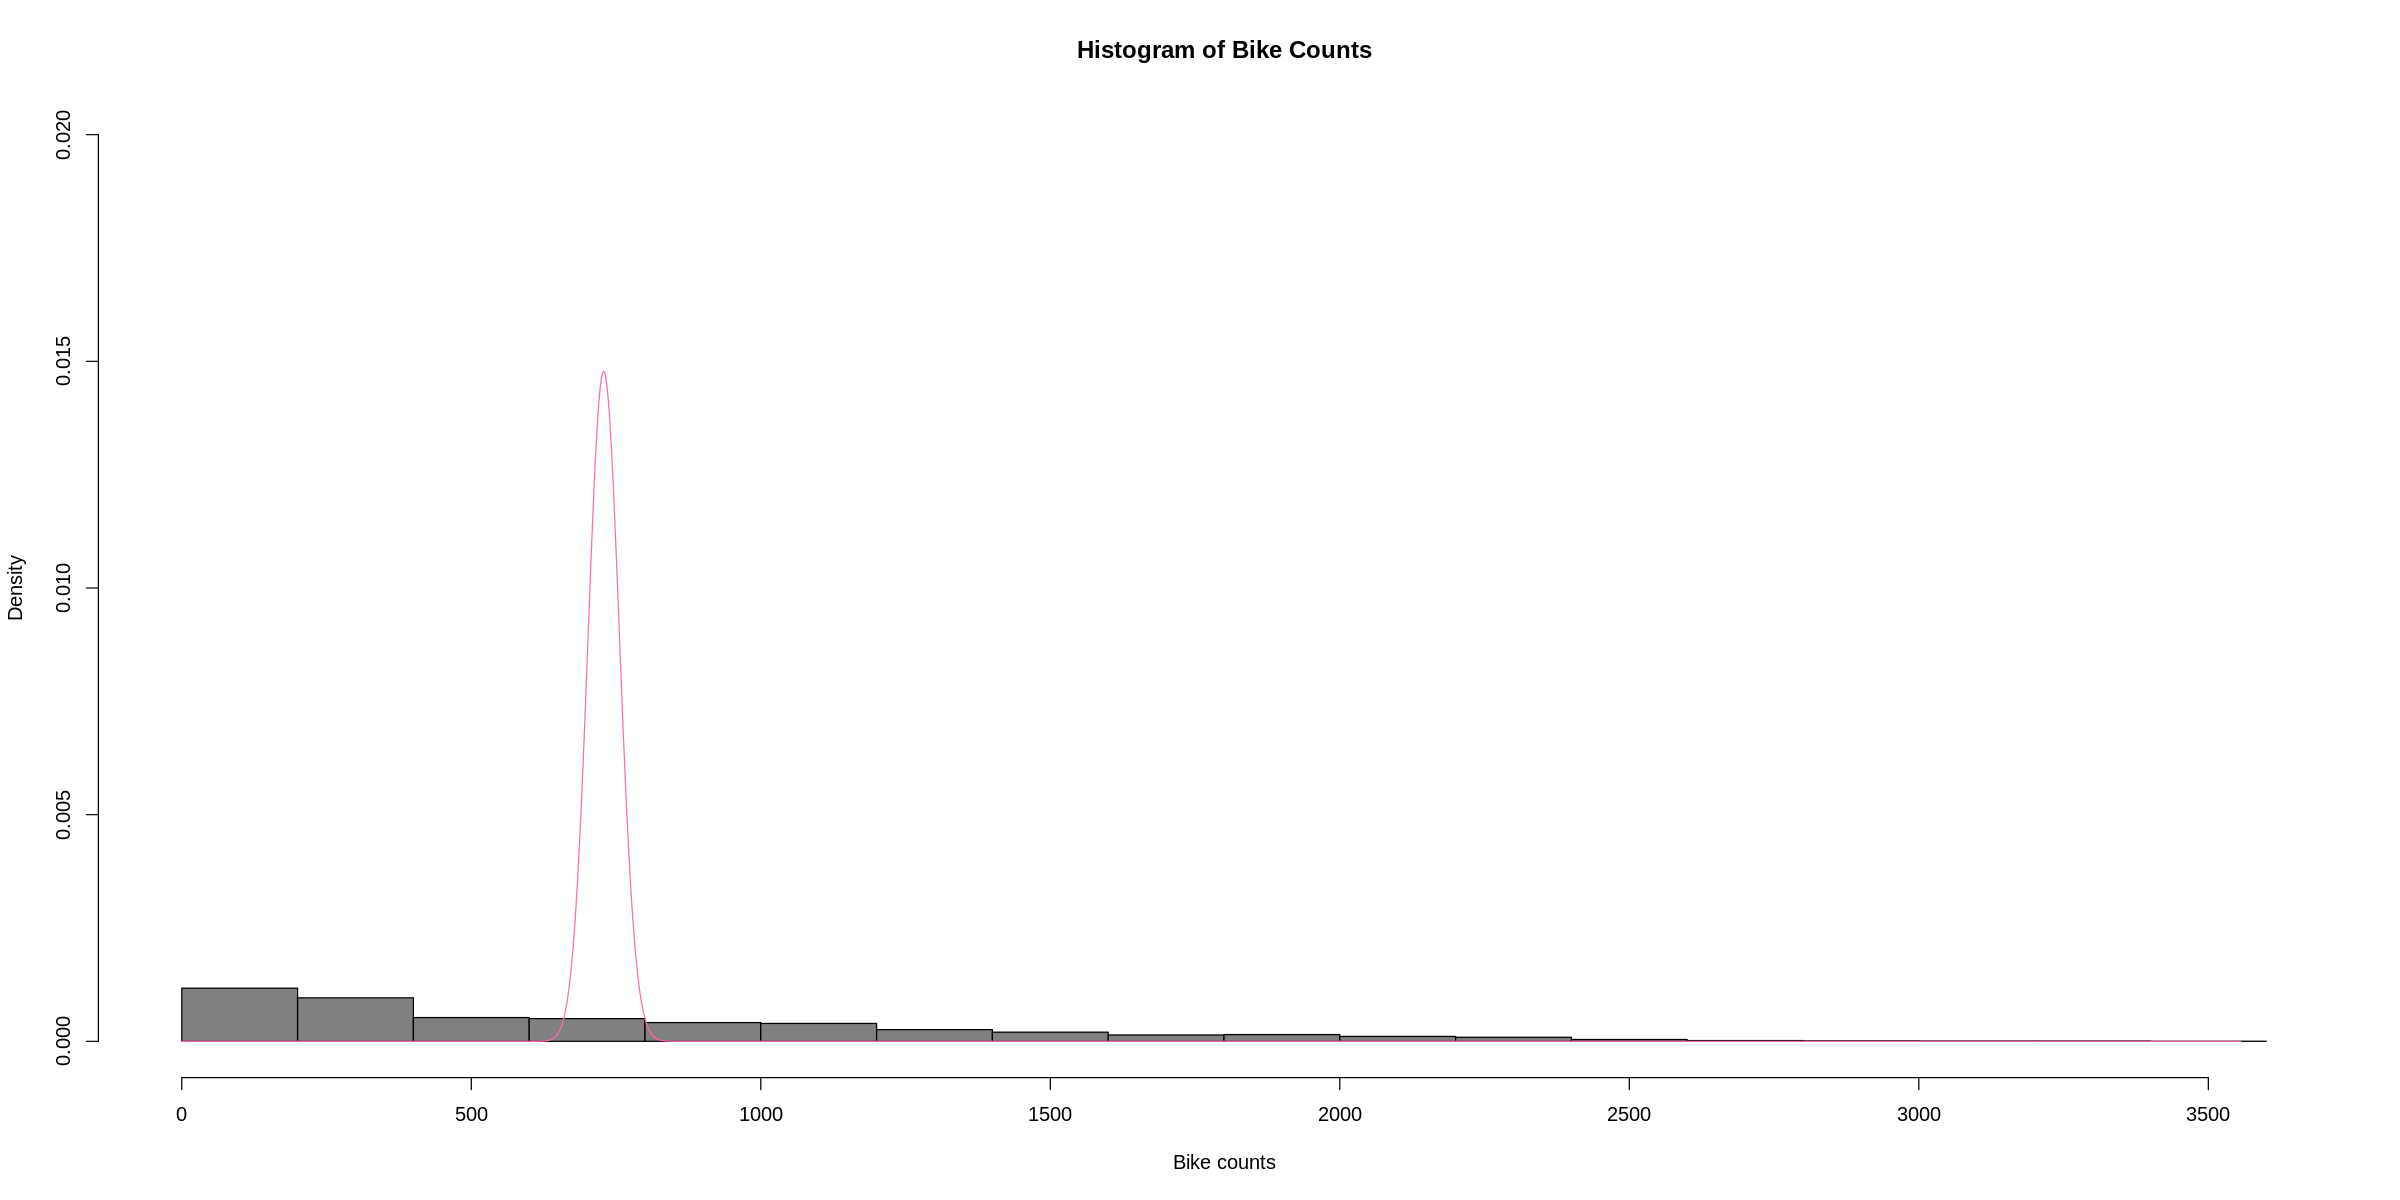

In [60]:
hist(bike$count, freq=FALSE, col=grey(0.5), ylim=c(0, 0.02), main="Histogram of Bike Counts", xlab="Bike counts")
  lines(0:max(bike$count), dpois(0:max(bike$count), mean(bike$count)), col="hotpink")

It appears that the pink line corresponding to a Poisson density with mean equal to that of the observed bike counts places more probability mass around 750 bike rentals whereas most of the actual observed bike counts are around 250 and under. This may be an early indication that the Poisson distribution is not appropriate for the dataset. 

We will proceed to fitting a Poisson distribution and check for further indications. 

In [61]:
poisson_model <- glm(formula = count~hour + temp + humidity + windspeed + visibility + solar + snow + seasons + holiday+month,
                     family = "poisson",
                     data = bike_training)
tidy(poisson_model)
glance(poisson_model)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),5.950953065,6.383440e-03,932.248582,0.000000e+00
hour,0.042050824,8.446915e-05,497.824667,0.000000e+00
temp,0.037675632,1.403405e-04,268.458710,0.000000e+00
humidity,-0.010686787,4.026528e-05,-265.409484,0.000000e+00
windspeed,0.012738001,5.386766e-04,23.646842,1.271997e-123
visibility,0.000072624,1.239150e-06,58.607922,0.000000e+00
solar,-0.088686224,6.955295e-04,-127.508934,0.000000e+00
snow,-0.118339005,2.516102e-03,-47.032668,0.000000e+00
seasonsSpring,-0.123421584,2.763621e-03,-44.659369,0.000000e+00


null.deviance,df.null,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
3189013,5924,-595085.3,1190211,1190344,1143227,5905,5925


In [62]:
deviance(poisson_model)/poisson_model$df.residual
dispersiontest(poisson_model)

[1] 193.6032


	Overdispersion test

data:  poisson_model
z = 34.098, p-value < 2.2e-16
alternative hypothesis: true dispersion is greater than 1
sample estimates:
dispersion 
    200.87 


The `residual deviance/df` is greater than 1 which suggests overdispersion. We can also use the `dispersiontest` from the `AER` package which tests the null hypothesis of equal mean and variance (i.e. equidispersion) against the alternative hypothesis $V[Y_i] = \lambda_i + c*f(\lambda_i)$ where the constant $c<0$ corresponds to underdispersion and $c>0$ corresponds to overdispersion. Effectively, this is testing $H_0: c = 0$ versus $H_1: c \neq 0$ using the t-statistic. Since the $c$ is estimated to be 200.87 and p-value < 0.05, this suggests evidence of overdispersion.

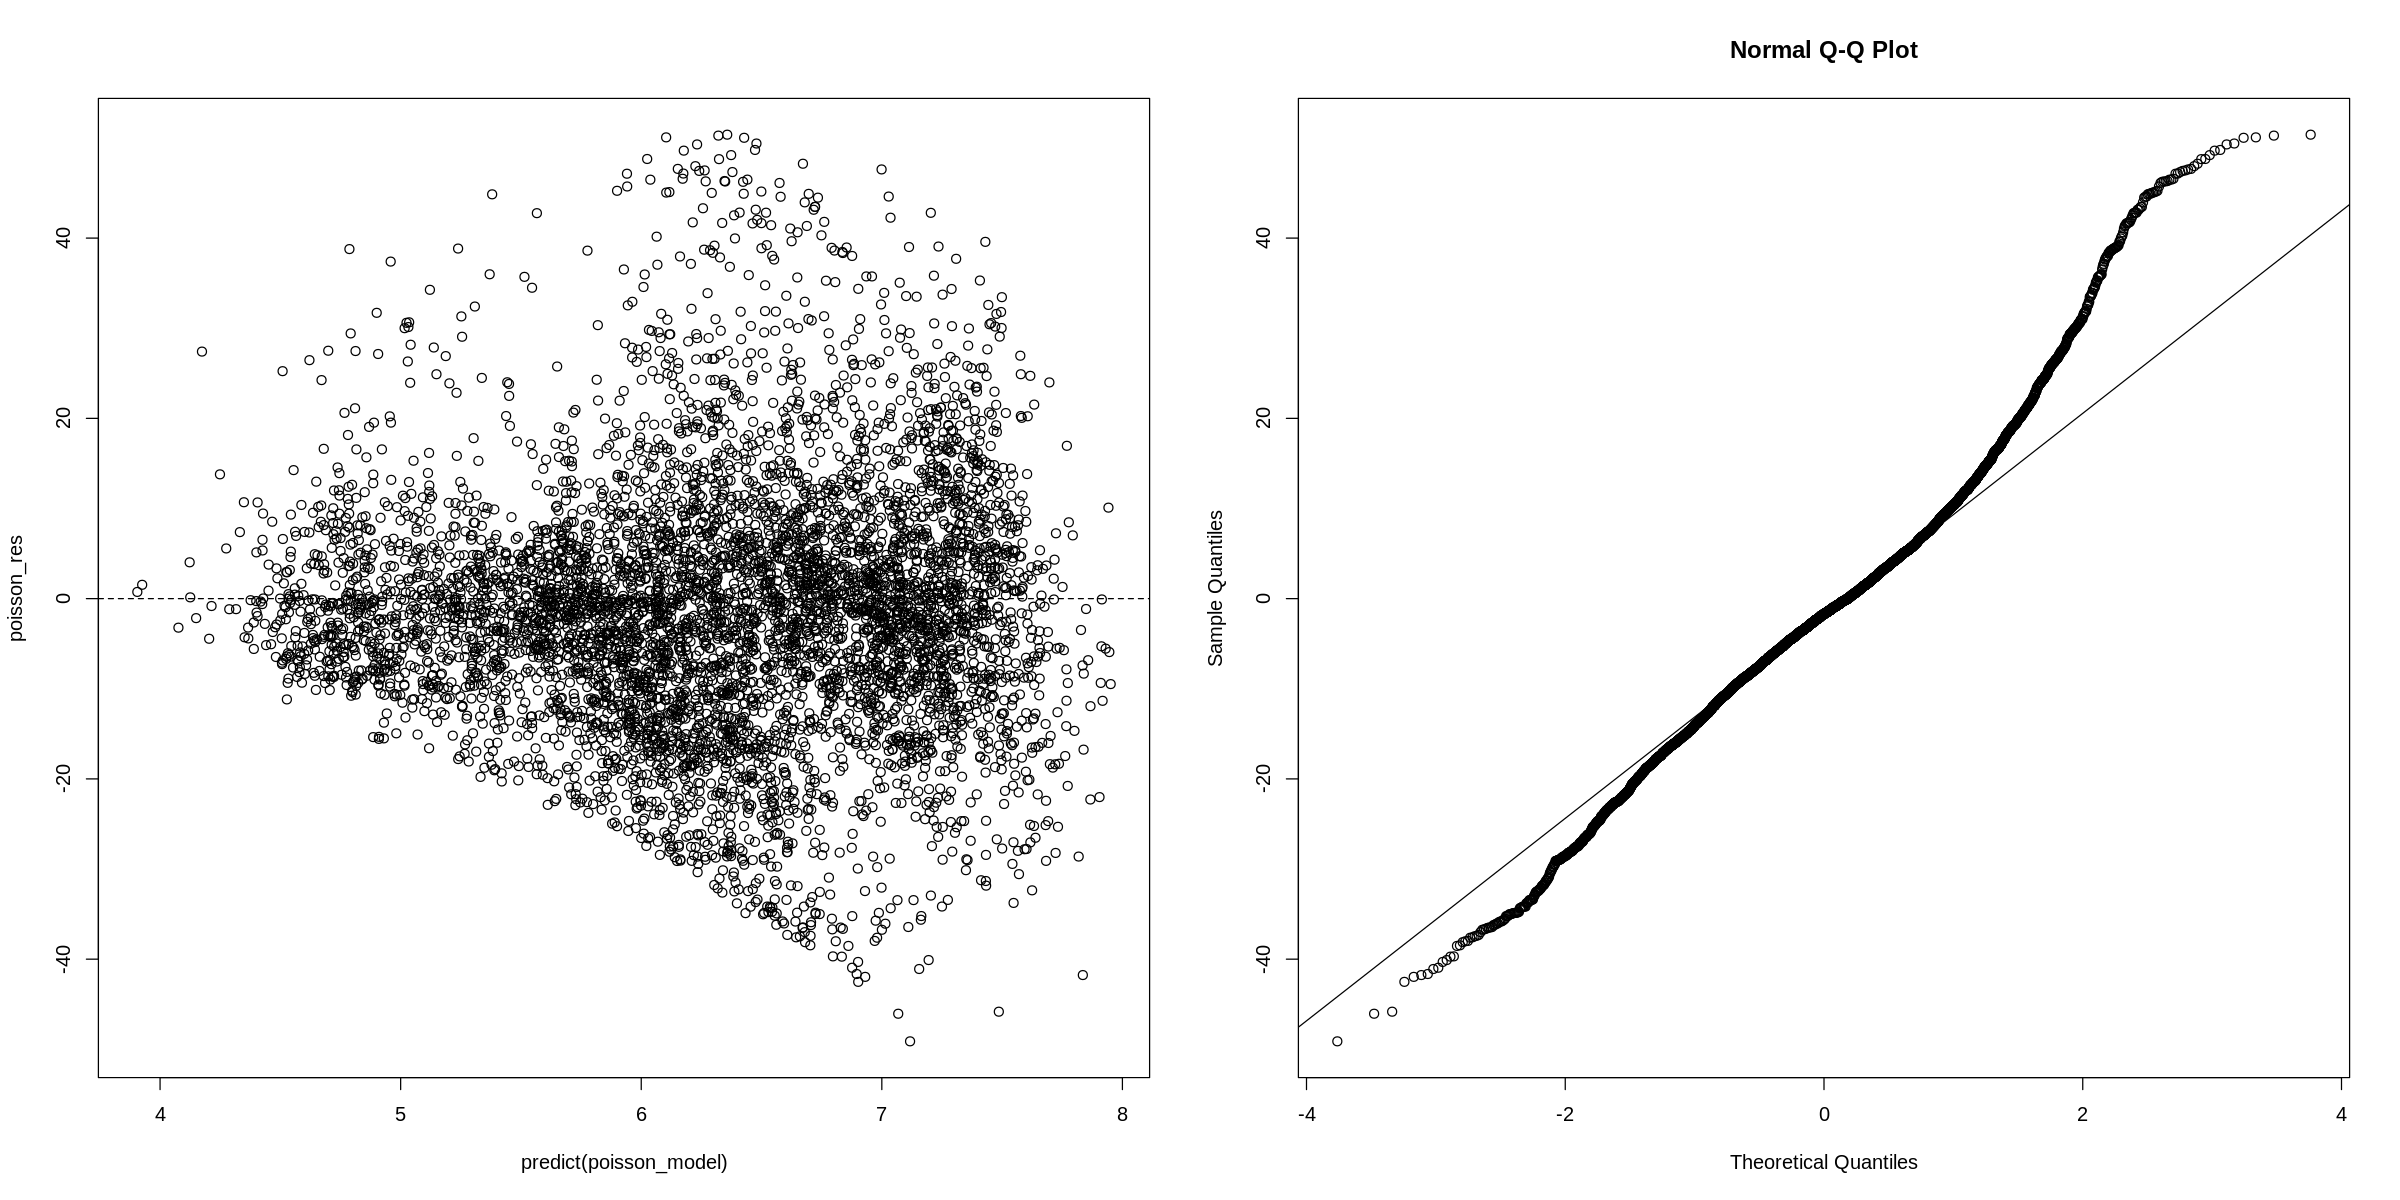

In [63]:
 # Residual plots
{options(repr.plot.width=20, repr.plot.height=10)
par(mfrow=c(1,2))
poisson_res <- residuals(poisson_model, type="deviance")
plot(predict(poisson_model), poisson_res)
abline(h=0, lty=2)
qqnorm(poisson_res)
qqline(poisson_res)
}

Furthermore, there appears to be funnel-like pattern in the reisduals which suggest that the Poisson distribution is not appropriate for this dataset. 

#### Negative Binomial Regression

To account for extra dispersion in Poisson models, we will use the **Negative Binomial** distribution instead of the Poisson distribution.

$$P(Y_i = y_i, \lambda_i, \theta) = \frac{\Gamma(\theta + y_i)}{\Gamma(y_i +1)\Gamma(\theta)} 
\left (\frac{\theta}{\theta + \lambda_i}\right)^{\theta}  \left (\frac{\lambda_i}{\theta + \lambda_i}\right)^{y_i}$$

Then:

$$E[Y_i]= \lambda_i$$

and 

$$V[Y_i] = \lambda_i + \lambda_i^2/\theta$$

Like Poisson, the negative binomial regression can be used to fit counts data. Moreover, the negative binomial model can be used when the variance of data is substancially higher than the mean. The overdispersion with respect to the Poisson distribution in this case is given by $\lambda_i^2/\theta$, which approaches 0 as $\theta$ increases.

We first fit a full negative binomial model with all variables in the data.

In [64]:
nbinomial_model <- glm.nb(
  formula = count~hour + temp + humidity + windspeed + visibility + solar + snow + seasons + holiday+month,
  data = bike_training
)
tidy(nbinomial_model)
glance(nbinomial_model)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),5.865914e+00,1.090751e-01,53.7786660,0.000000e+00
hour,3.931012e-02,1.360162e-03,28.9010498,1.158201e-183
temp,4.206379e-02,2.211003e-03,19.0247579,1.063776e-80
humidity,-1.179924e-02,7.053448e-04,-16.7283301,8.149123e-63
windspeed,-1.611553e-02,9.281790e-03,-1.7362524,8.251922e-02
visibility,5.394893e-05,2.081438e-05,2.5919073,9.544548e-03
solar,-4.863457e-02,1.355430e-02,-3.5881276,3.330612e-04
snow,-1.115817e-01,2.084917e-02,-5.3518519,8.705863e-08
seasonsSpring,-1.216032e-01,5.052088e-02,-2.4069886,1.608467e-02


null.deviance,df.null,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<int>,<logLik>,<dbl>,<dbl>,<dbl>,<int>,<int>
14169.94,5924,-42340.31,84722.63,84863.06,6355.149,5905,5925


In [65]:
# Goodness-of-fit test
gof.pvalue = 1 - pchisq(nbinomial_model$deviance, nbinomial_model$df.residual)
print(paste0("p-value of LRT: ", round(gof.pvalue,4)))

[1] "p-value of LRT: 0"


The likelihood ratio test comparing the "saturated model" vs. the current model shows a p-value smaller than 0.05, which means there remains a significant lack of fit.

In [66]:
# Dispersion
dis <- nbinomial_model$theta
print(paste0("Dispersion parameter: ", round(dis,2)))

[1] "Dispersion parameter: 2.39"


The overdispersion parameter with respect to the Poisson distribution is 2.39.

We then use backward selection method to select an optimal subset of variables which minimizes the value of AIC.

In [67]:
# AIC stepwise selection
AIC_nbinomial_model <- stepAIC(nbinomial_model, k = log(nrow(bike_training)),
                                  direction = "backward", trace = 1)

Start:  AIC=84854.37
count ~ hour + temp + humidity + windspeed + visibility + solar + 
    snow + seasons + holiday + month


Step:  AIC=84854.37
count ~ hour + temp + humidity + windspeed + visibility + solar + 
    snow + holiday + month

             Df   AIC
- windspeed   1 84849
- visibility  1 84852
<none>          84854
- solar       1 84858
- snow        1 84870
- holiday     1 84909
- humidity    1 85085
- temp        1 85190
- hour        1 85571
- month      11 85732

Step:  AIC=84848.62
count ~ hour + temp + humidity + visibility + solar + snow + 
    holiday + month

             Df   AIC
- visibility  1 84846
<none>          84849
- solar       1 84856
- snow        1 84864
- holiday     1 84903
- humidity    1 85078
- temp        1 85184
- hour        1 85587
- month      11 85751

Step:  AIC=84845.91
count ~ hour + temp + humidity + solar + snow + holiday + month

           Df   AIC
<none>        84846
- solar     1 84856
- snow      1 84862
- holiday   1 84902
- temp

Variables selected by AIC stepwise selection are: hour, temp, humidity, solar, snow, holiday, month

In [68]:
tidy(AIC_nbinomial_model)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),5.87555260,0.0658697471,89.199562,0.000000e+00
hour,0.03889281,0.0013147893,29.581023,2.621686e-192
temp,0.04008736,0.0020721208,19.346052,2.200672e-83
humidity,-0.01287081,0.0005386854,-23.892994,3.621978e-126
solar,-0.05774420,0.0130661933,-4.419359,9.899414e-06
snow,-0.11229193,0.0208576059,-5.383740,7.295377e-08
holidayNo Holiday,0.34693455,0.0411992432,8.420896,3.736149e-17
monthAugust,-0.24144698,0.0521484150,-4.629996,3.656719e-06
monthDecember,-0.34370092,0.0502581679,-6.838708,7.991075e-12


After getting the best reduced model, we will use the residual v.s prediction plot and QQ plot to diagnose the reduced model.

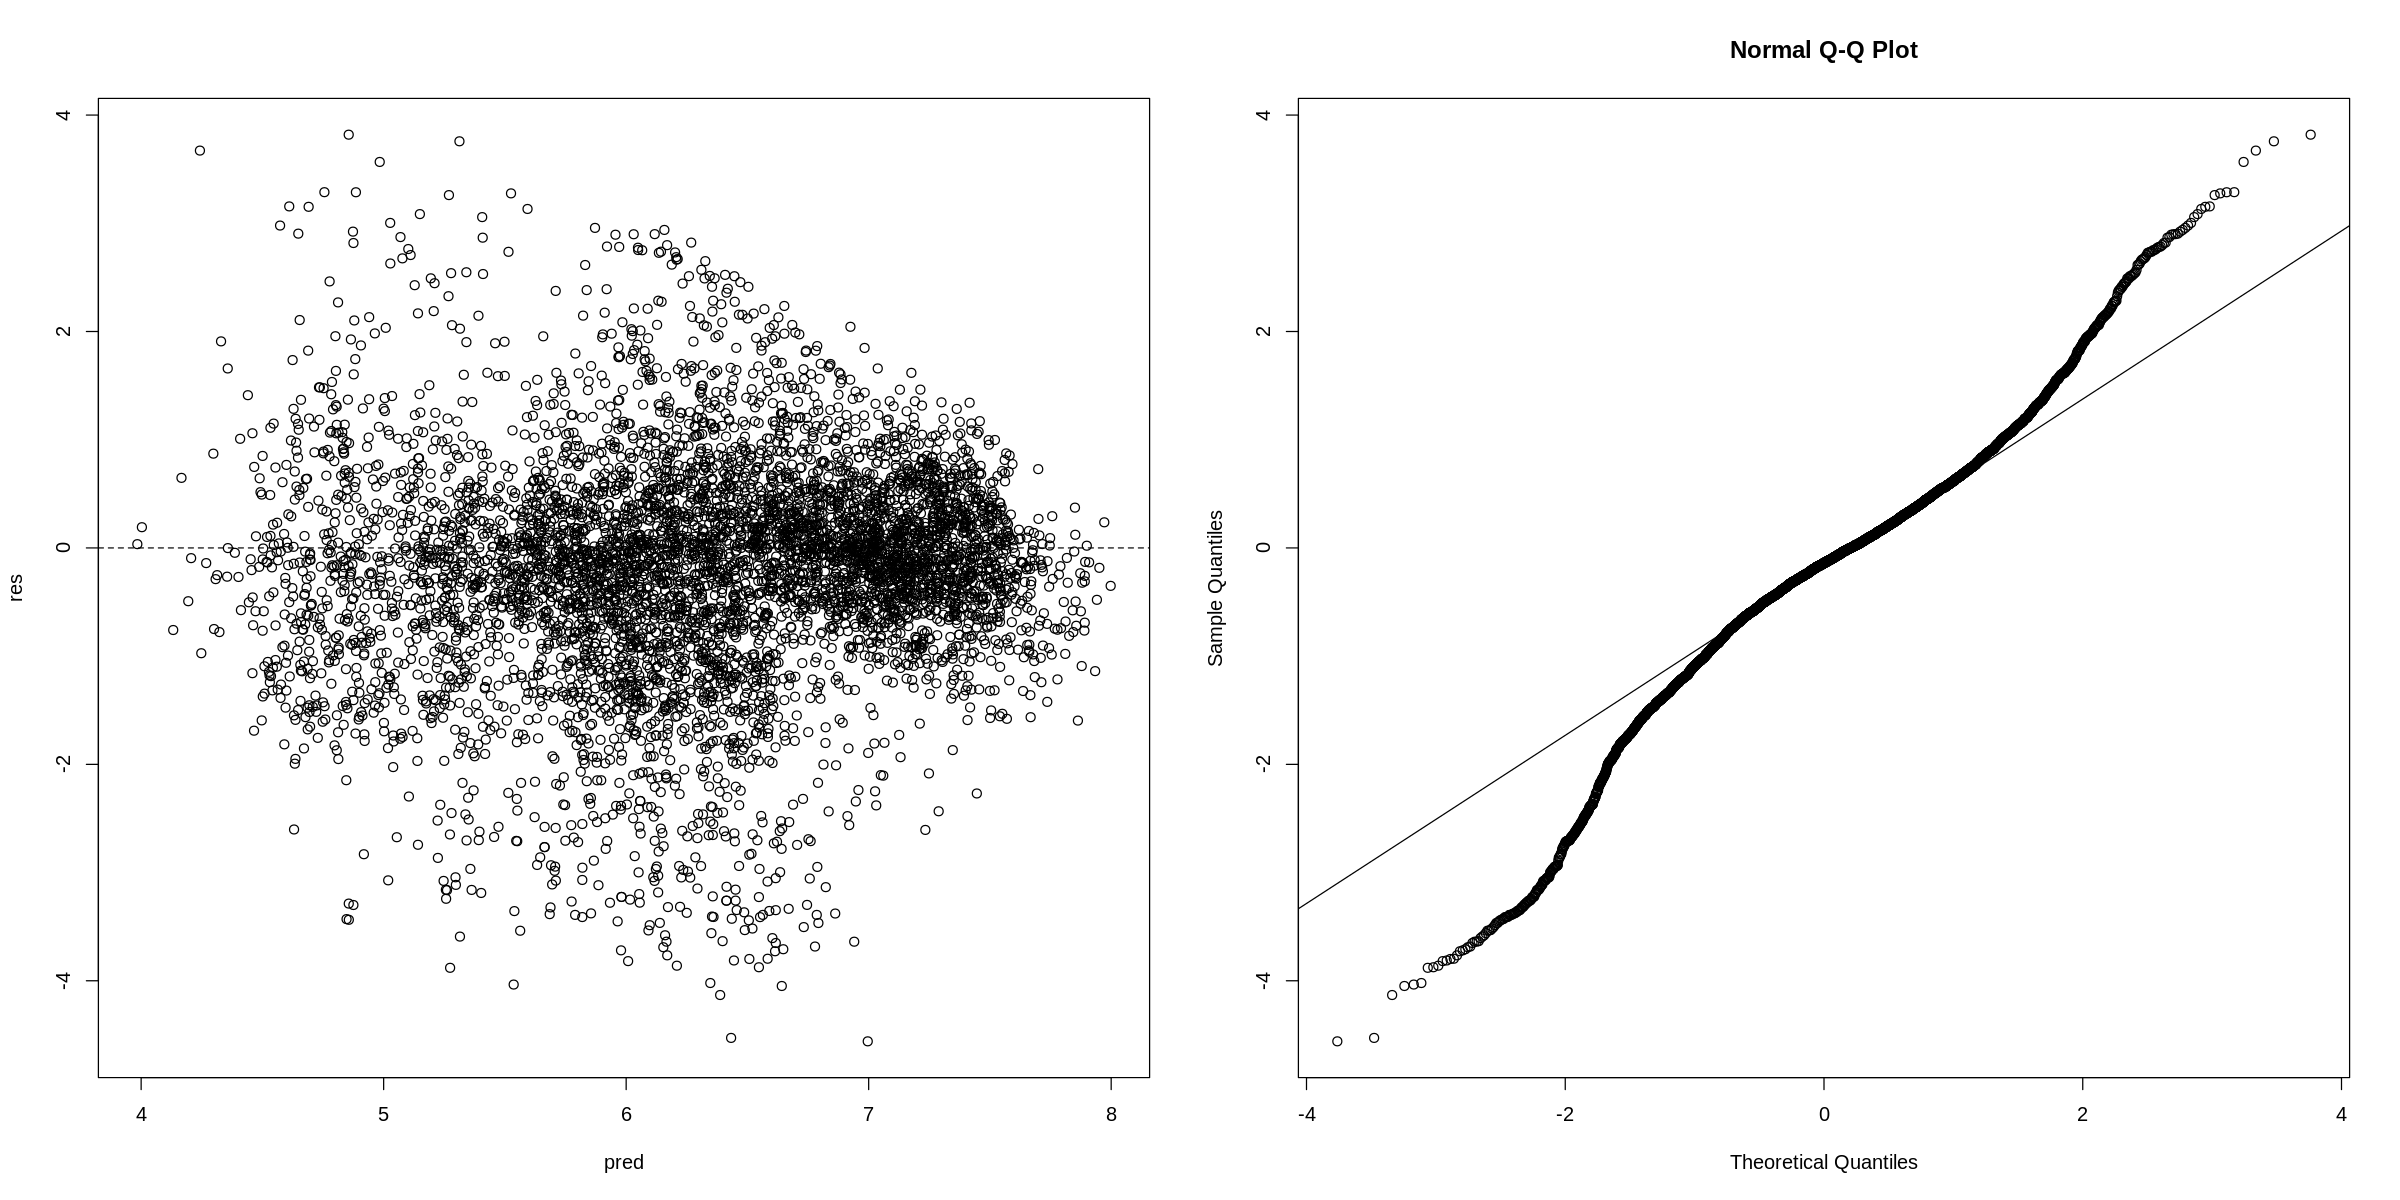

In [69]:
options(repr.plot.width=20, repr.plot.height=10)
par(mfrow=c(1,2))
res <- residuals(AIC_nbinomial_model, type="deviance")
pred <- predict(AIC_nbinomial_model)
plot(pred, res)
abline(h=0, lty=2)
qqnorm(res)
qqline(res)

DHARMa:testOutliers with type = binomial may have inflated Type I error rates for integer-valued distributions. To get a more exact result, it is recommended to re-run testOutliers with type = 'bootstrap'. See ?testOutliers for details



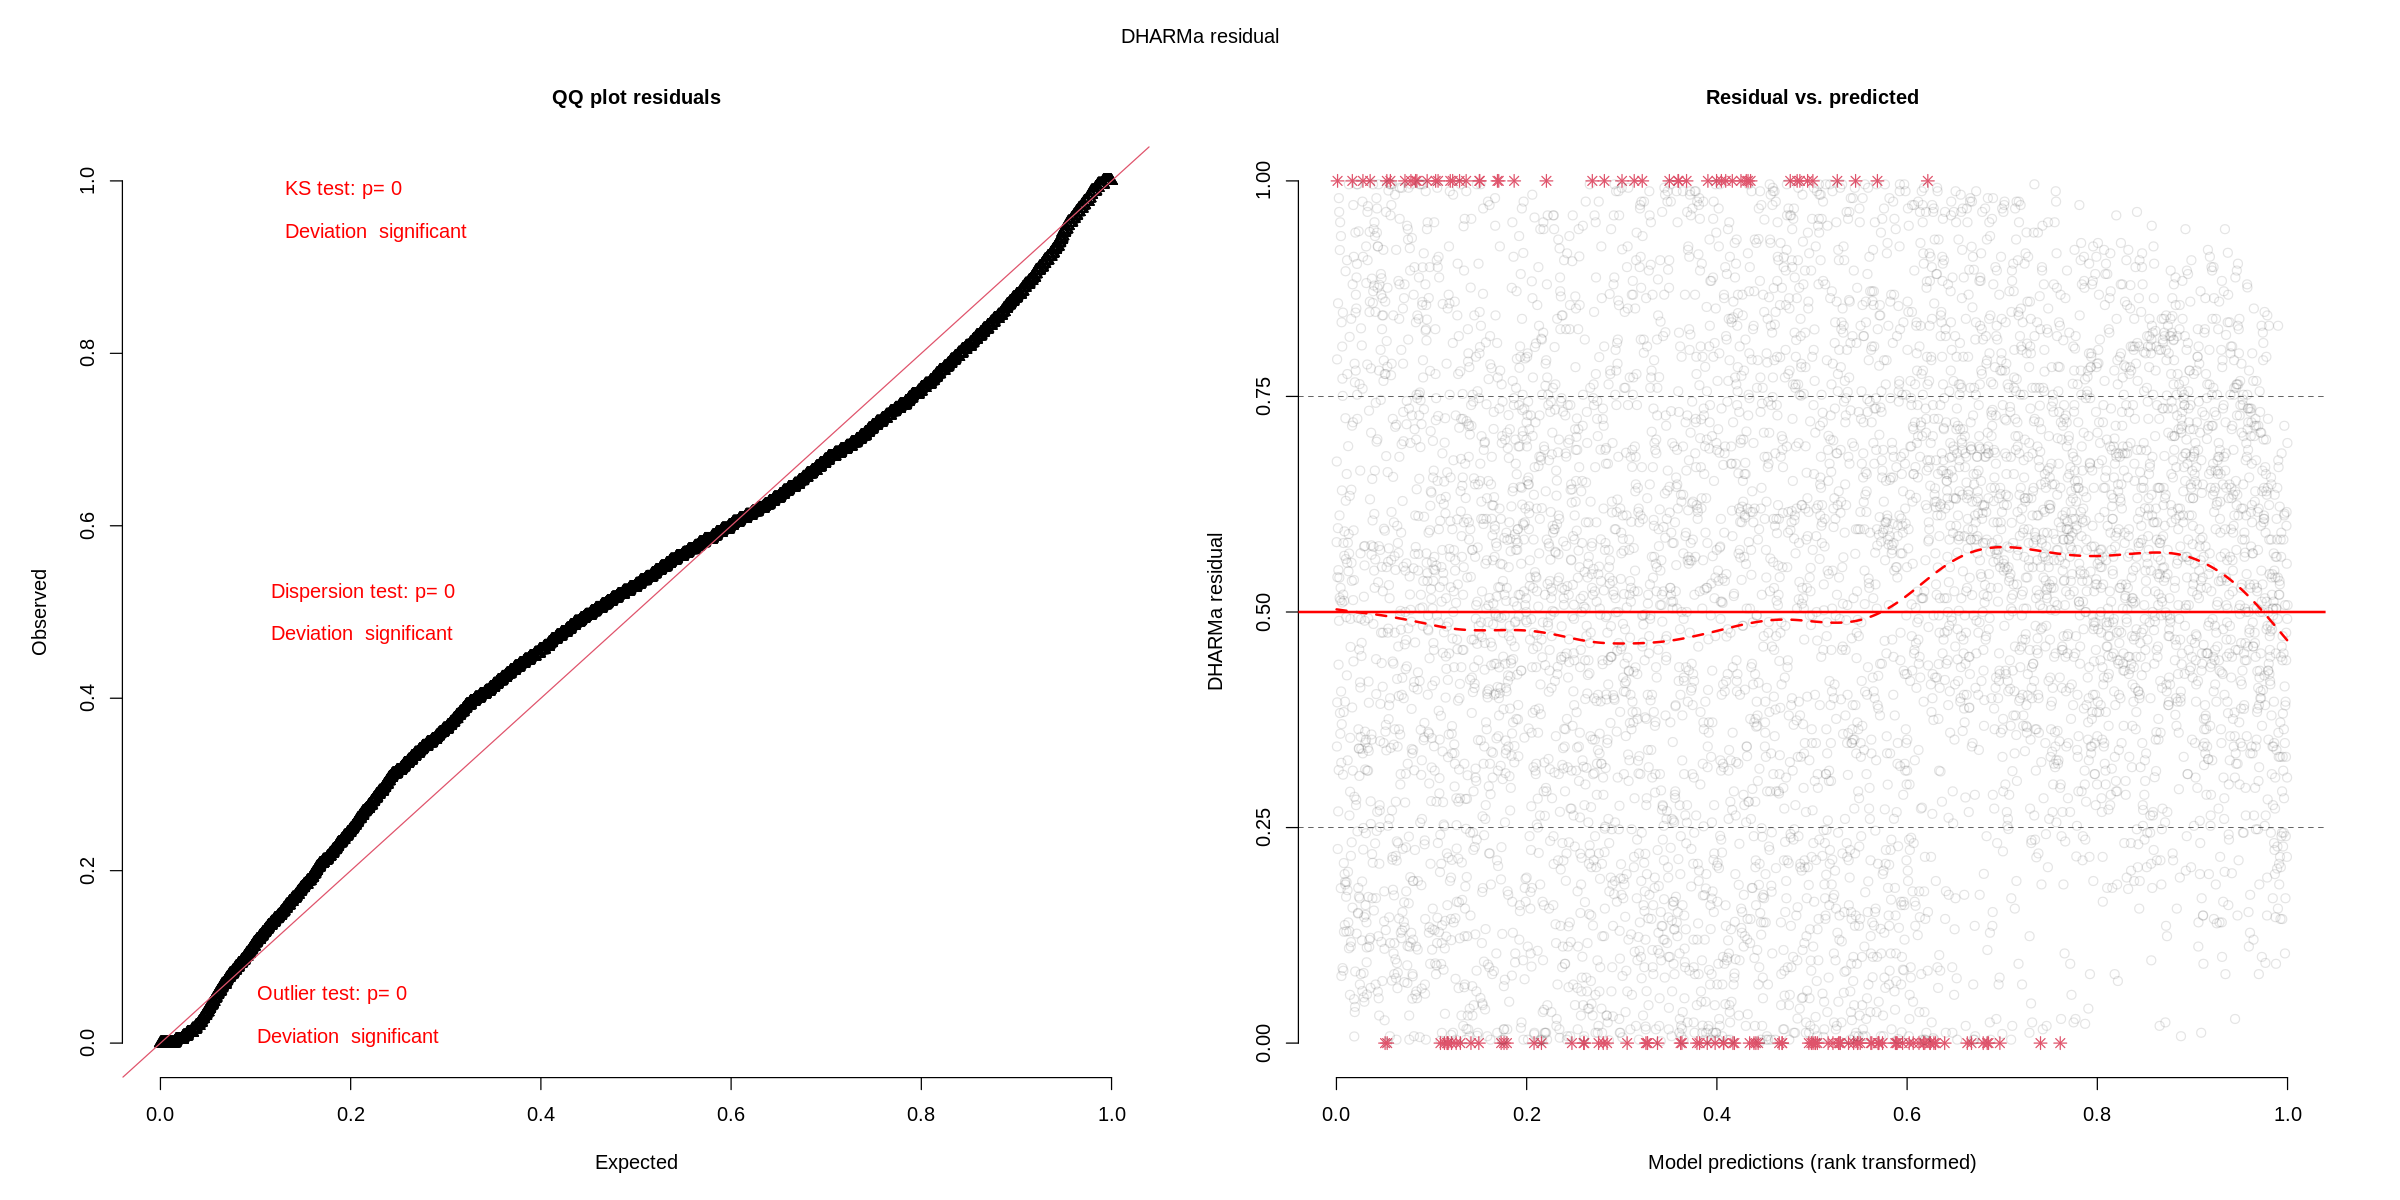

In [70]:
n_sim <- 250
simulationOutput <- simulateResiduals(fittedModel = AIC_nbinomial_model, n = n_sim)
plot(simulationOutput, asFactor = F)

##### Compare full model and reduced model

In [71]:
t <- as.data.frame(rbind(glance(nbinomial_model),glance(AIC_nbinomial_model)))
rownames(t) <- c("nbinomial","AIC_nbinomial")
t  %>% dplyr::select(-c(df.residual,nobs,df.null))  %>% 
        mutate(n_coef = c(length(coef(nbinomial_model)),length(coef(AIC_nbinomial_model)))) %>% 
        mutate(overdispersion = c(nbinomial_model$theta,AIC_nbinomial_model$theta)) #%>% 
       # mutate(gof.pvalue = c(1 - pchisq(nbinomial_model$deviance, nbinomial_model$df.residual),
       #                      1 - pchisq(AIC_nbinomial_model$deviance, AIC_nbinomial_model$df.residual)))

,null.deviance,logLik,AIC,BIC,deviance,n_coef,overdispersion
,<dbl>,<logLik>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
nbinomial,14169.94,-42340.31,84722.63,84863.06,6355.149,23,2.385162
AIC_nbinomial,14151.01,-42344.77,84727.54,84854.59,6355.613,18,2.381945


In [72]:
anova(nbinomial_model,AIC_nbinomial_model)

Model,theta,Resid. df,2 x log-lik.,Test,df,LR stat.,Pr(Chi)
<chr>,<dbl>,<int>,<dbl>,<chr>,<int>,<dbl>,<dbl>
hour + temp + humidity + solar + snow + holiday + month,2.381945,5907,-84689.54,,NA,NA,NA
hour + temp + humidity + windspeed + visibility + solar + snow + seasons + holiday + month,2.385162,5905,-84680.63,1 vs 2,2,8.912292,0.01160701


There are only 18 coefficients in the reduced model. Overdispersion parameter in the reduced model is slightly lower than that in the full model, which implies larger dispersion with respect to Poisson regression. P-value of likelihood ratio test between full model and reduced model is smaller than 0.05, which indicates that the reduced model selected by AIC is significantly better than the full model under 5% significance level.

### 2.3 Model Evaluation

## 3. Discussion

## 4. References